# --- PART 1: SETUP AND DATA LOADING ---


In [ ]:
# --- PART 1: SETUP AND DATA LOADING ---

# Install required packages if needed
# Uncomment if you need to install xgboost
#!pip install xgboost

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv('bank-full.csv', sep=';')


# --- PART 2: DATA PREPROCESSING ---


In [ ]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.cluster import KMeans
import shap
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('bank-full.csv', sep=';')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['y'].value_counts()}")
print(f"Subscription rate: {df[df['y']=='yes'].shape[0] / df.shape[0]:.2%}")
imputer = SimpleImputer(strategy='mean') # or 'median', or other strategies


# Convert categorical variables to dummy variables
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                   'loan', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Convert binary target to numeric
df_encoded['y'] = df_encoded['y'].map({'yes': 1, 'no': 0})

# Feature engineering
df_encoded['previous_contact'] = df_encoded['pdays'].apply(lambda x: 0 if x == -1 else 1)
df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=[18, 30, 40, 50, 60, 100],
                                labels=[1, 2, 3, 4, 5])
df_encoded['wealthy'] = ((df_encoded['balance'] > df_encoded['balance'].median()) &
                        (df_encoded['housing_yes'] == 0) &
                        (df_encoded['loan_yes'] == 0)).astype(int)

# Split features and target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42, stratify=y)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)




Dataset shape: (45211, 17)
Target distribution:
y
no     39922
yes     5289
Name: count, dtype: int64
Subscription rate: 11.70%


# --- PART 3: MODEL TRAINING AND EVALUATION ---

In [ ]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=9,
        class_weight='balanced',
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=80,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

# Function to train and evaluate models
def train_evaluate_models(models, X_train, y_train, X_test, y_test):
    """Train and evaluate multiple models, returning performance metrics and trained models"""
    results = {}

    for name, model in models.items():
        print(f"\n=== Training {name} ===")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_proba)

        # Print results
        print(f"Model: {name}")
        print(f"ROC AUC: {auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Store results
        results[name] = {'model': model, 'auc': auc}

    return results

# Train and evaluate models
results = train_evaluate_models(models, X_train_scaled, y_train, X_test_scaled, y_test)

# Select best model
best_model_name = max(results, key=lambda k: results[k]['auc'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with AUC {results[best_model_name]['auc']:.4f}")

# Save best model and scaler
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Best model and scaler saved to disk.")



=== Training Random Forest ===
Model: Random Forest
ROC AUC: 0.9137

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7985
           1       0.41      0.85      0.55      1058

    accuracy                           0.84      9043
   macro avg       0.69      0.84      0.72      9043
weighted avg       0.91      0.84      0.86      9043


=== Training Gradient Boosting ===
Model: Gradient Boosting
ROC AUC: 0.9285

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.65      0.45      0.54      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.71      0.74      9043
weighted avg       0.90      0.91      0.90      9043


=== Training XGBoost ===
Model: XGBoost
ROC AUC: 0.9307

Classification Report:
              precision    recall  f1-score   support

           0    

# --- PART 4: ROI CALCULATION ---

In [ ]:
def calculate_roi(model, X_test, y_test, avg_deposit=5000, profit_margin=0.05, contact_cost=10):
    """Calculate ROI and other business metrics for marketing campaign optimization"""

    print("\n=== Business Impact Analysis (ROI) ===")

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Create dataframe with predictions for analysis
    results_df = pd.DataFrame({
        'actual': y_test,
        'probability': y_pred_proba
    })

    # Calculate ROI at different thresholds
    thresholds = np.arange(0.1, 0.9, 0.1)
    roi_metrics = []

    for threshold in thresholds:
        # Apply threshold
        results_df['predicted'] = (results_df['probability'] >= threshold).astype(int)

        # Calculate metrics
        true_positives = sum((results_df['predicted'] == 1) & (results_df['actual'] == 1))
        false_positives = sum((results_df['predicted'] == 1) & (results_df['actual'] == 0))
        targeted_contacts = sum(results_df['predicted'])

        # Baseline approach (contact everyone)
        total_contacts = len(y_test)
        baseline_cost = total_contacts * contact_cost
        baseline_revenue = sum(y_test) * avg_deposit * profit_margin
        baseline_profit = baseline_revenue - baseline_cost
        baseline_roi = baseline_profit / baseline_cost if baseline_cost > 0 else 0

        # Targeted approach
        targeted_cost = targeted_contacts * contact_cost
        targeted_revenue = true_positives * avg_deposit * profit_margin
        targeted_profit = targeted_revenue - targeted_cost
        targeted_roi = targeted_profit / targeted_cost if targeted_cost > 0 else 0

        # Calculate savings and improvements
        cost_reduction = baseline_cost - targeted_cost
        profit_improvement = targeted_profit - baseline_profit
        roi_improvement = targeted_roi - baseline_roi

        # Store metrics
        roi_metrics.append({
            'threshold': threshold,
            'targeted_contacts': targeted_contacts,
            'total_contacts': total_contacts,
            'targeted_percentage': targeted_contacts/total_contacts*100,
            'true_positives': true_positives,
            'conversion_rate': true_positives/targeted_contacts*100 if targeted_contacts > 0 else 0,
            'baseline_roi': baseline_roi*100,
            'targeted_roi': targeted_roi*100,
            'baseline_profit': baseline_profit,
            'targeted_profit': targeted_profit,
            'roi_improvement': roi_improvement*100,
            'cost_reduction': cost_reduction,
            'profit_improvement': profit_improvement
        })

    # Convert to DataFrame
    roi_df = pd.DataFrame(roi_metrics)

    # Find optimal threshold - now based on profit improvement, not just ROI
    # This ensures we prioritize actual profit, not just percentage return
    optimal_idx = roi_df['profit_improvement'].idxmax()
    optimal_threshold = roi_df.loc[optimal_idx, 'threshold']

    # Plot ROI metrics across thresholds
    plt.figure(figsize=(14, 10))

    # Plot 1: ROI comparison
    plt.subplot(3, 1, 1)
    plt.plot(roi_df['threshold'], roi_df['targeted_roi'], 'b-', marker='o', label='Targeted ROI (%)')
    plt.plot(roi_df['threshold'], roi_df['baseline_roi'], 'r--', label='Baseline ROI (%)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--',
                label=f'Optimal threshold: {optimal_threshold:.1f}')
    plt.title('ROI by Threshold')
    plt.xlabel('Probability Threshold')
    plt.ylabel('ROI (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Profit comparison
    plt.subplot(3, 1, 2)
    plt.plot(roi_df['threshold'], roi_df['targeted_profit'], 'g-', marker='o', label='Targeted Profit ($)')
    plt.plot(roi_df['threshold'], [roi_df['baseline_profit'].iloc[0]]*len(roi_df), 'r--',
             label='Baseline Profit ($)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--')
    plt.title('Profit by Threshold')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Profit ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Contact strategy
    plt.subplot(3, 1, 3)
    plt.plot(roi_df['threshold'], roi_df['targeted_percentage'], 'g-', marker='o',
             label='% Customers Contacted')
    plt.plot(roi_df['threshold'], roi_df['conversion_rate'], 'purple', marker='s',
             label='Conversion Rate (%)')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Get results for optimal threshold and fixed 0.5 threshold
    optimal_result = roi_df.loc[optimal_idx]
    fixed_threshold_result = roi_df[roi_df['threshold'] == 0.5].iloc[0] if any(roi_df['threshold'] == 0.5) else None

    # Print results for optimal threshold
    print(f"\nBusiness Impact Analysis (Optimal Threshold = {optimal_threshold:.2f}):")
    print(f"Contact only {optimal_result['targeted_percentage']:.1f}% of customers")
    print(f"Conversion rate: {optimal_result['conversion_rate']:.2f}%")
    print(f"Baseline profit: ${optimal_result['baseline_profit']:,.2f}")
    print(f"Targeted profit: ${optimal_result['targeted_profit']:,.2f}")
    print(f"Profit improvement: ${optimal_result['profit_improvement']:,.2f}")
    print(f"ROI improvement: {optimal_result['roi_improvement']:.2f}%")

    # Compare with fixed threshold of 0.5 if available
    if fixed_threshold_result is not None:
        print("\nComparison with fixed threshold (0.5):")
        print(f"Contact {fixed_threshold_result['targeted_percentage']:.1f}% of customers")
        print(f"Profit: ${fixed_threshold_result['targeted_profit']:,.2f}")
        print(f"Profit improvement: ${fixed_threshold_result['profit_improvement']:,.2f}")

    # Visualize ROI comparison at optimal threshold
    plt.figure(figsize=(10, 6))
    plt.bar(['Baseline', 'Targeted (Optimal)'],
           [optimal_result['baseline_profit'], optimal_result['targeted_profit']],
           color=['skyblue', 'orange'])
    plt.ylabel('Profit ($)')
    plt.title('Profit Comparison at Optimal Threshold')
    for i, v in enumerate([optimal_result['baseline_profit'], optimal_result['targeted_profit']]):
        plt.text(i, v + 1000, f"${v:,.2f}", ha='center')
    plt.show()

    return {
        'roi_df': roi_df,
        'optimal_threshold': optimal_threshold,
        'baseline_roi': optimal_result['baseline_roi'],
        'targeted_roi': optimal_result['targeted_roi'],
        'baseline_profit': optimal_result['baseline_profit'],
        'targeted_profit': optimal_result['targeted_profit'],
        'roi_improvement': optimal_result['roi_improvement'],
        'profit_improvement': optimal_result['profit_improvement']
    }



=== Business Impact Analysis (ROI) ===


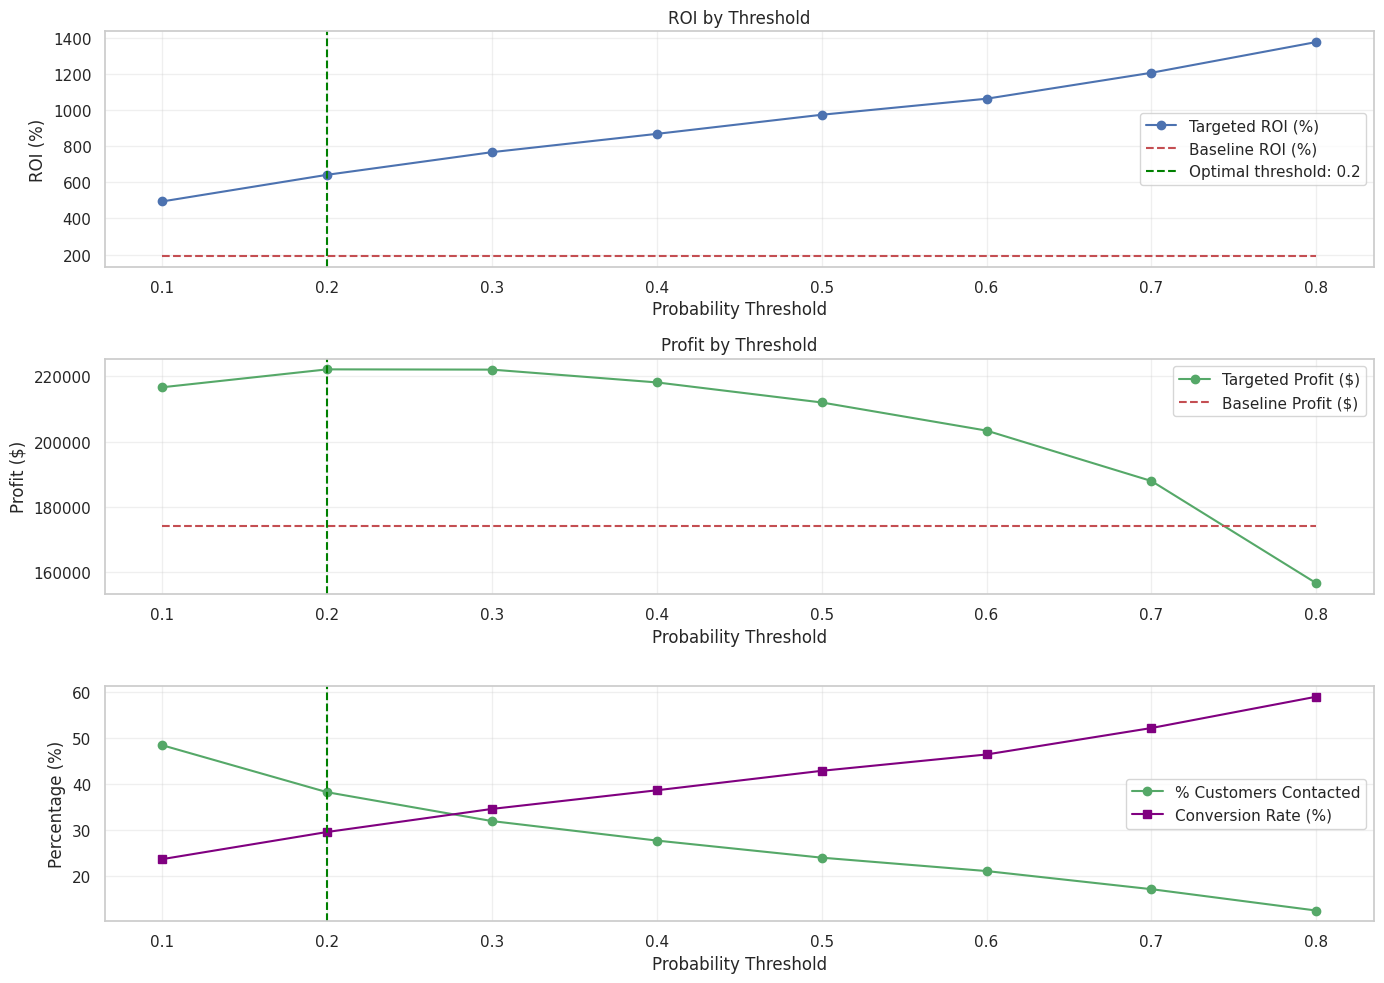


Business Impact Analysis (Optimal Threshold = 0.20):
Contact only 38.3% of customers
Conversion rate: 29.66%
Baseline profit: $174,070.00
Targeted profit: $222,120.00
Profit improvement: $48,050.00
ROI improvement: 448.92%

Comparison with fixed threshold (0.5):
Contact 24.1% of customers
Profit: $211,980.00
Profit improvement: $37,910.00


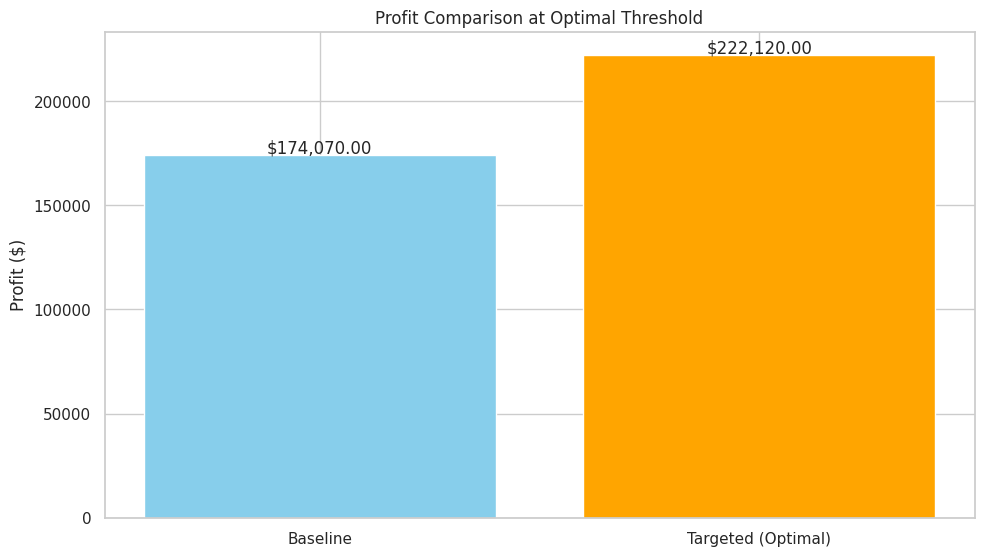

Optimal threshold: 0.2
Profit improvement: $48,050.00


In [ ]:
roi_results = calculate_roi(best_model, X_test_scaled, y_test)

# Accessing the results
print(f"Optimal threshold: {roi_results['optimal_threshold']}")
print(f"Profit improvement: ${roi_results['profit_improvement']:,.2f}")